# MobileNetV3-YOLOv3 COCO-Text Detection

In [1]:
import gc
import os
import math
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch_optimizer as optim
import matplotlib.patches as patches
import torch.nn.utils.prune as prune
import torchvision.transforms.functional as TF

from pathlib import Path
from datasets import load_dataset
from torchvision import transforms
from torch.nn import functional as F
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from mobileyolov3 import MobileYOLOv3, DSConv, Resizer

%matplotlib inline

---

## Hyperparameters

In [2]:
# CPU Seed for Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GPU Seed for Reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"Using training device: {device}")

batch_size = 128
num_workers = 4
num_classes = 1
learning_rate = 4e-4
num_epochs = 400
lr_warmup = num_epochs * 0.1
weight_decay = 1e-4
optim_k = 5
optim_alpha = 0.3
prune_amount = 0.2
dropout_rate = 0.4
t_arch = str(device)
global_img_size = (600, 600)
anchors = [(0.28, 0.35), (0.43, 0.58), (0.62, 0.78)]
num_anchors = len(anchors)
model_path = 'mobileyolov3_coco-text.pth'

Using training device: cuda


---

## Dataset

In [3]:
# load_dataset by default loads to system drive and caches to home dir
# this is more flexible

down_dir = Path("/mnt/data/")
target_path = down_dir / "COCO-Text"
cache_path = down_dir / "COCO-Text_Cache"

if not os.path.exists(target_path):
    os.makedirs(target_path)
    os.makedirs(cache_path, exist_ok=True)

    dataset_id = "howard-hou/COCO-Text"

    print(f"Downloading {dataset_id}...")

    while True:
        try:
            snapshot_download(dataset_id, repo_type="dataset", cache_dir=str(cache_path), local_dir=str(target_path))
            break
        except Exception as _:
            continue
else:
    print(f"Dataset already exists at {target_path}. Proceed.")

Dataset already exists at /mnt/data/COCO-Text. Proceed.


In [4]:
class COCOText(Dataset):
    """
    COCO-Text Dataset adapter for YOLOv3 training, loading from a local directory.
    """
    def __init__(self, num_classes=1, num_anchors=3, img_size=global_img_size, anchors=anchors, split="train"):
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.img_size = img_size
        self.anchors = anchors
        self.batch_count = 0
        self.coarse = (7, 7, self.num_anchors * (5 + self.num_classes))
        self.medium = (14, 14, self.num_anchors * (5 + self.num_classes))
        self.fine = (28, 28, self.num_anchors * (5 + self.num_classes))
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ColorJitter(brightness=0.1, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomAdjustSharpness(sharpness_factor=3.0, p=0.9),
            transforms.ToTensor()
        ])

        # Load the dataset from the local directory 
        # akin to https://stackoverflow.com/questions/77020278/how-to-load-a-huggingface-dataset-from-local-path
        # I named the split exactly like the original, you can change it to your liking
        self.dataset = load_dataset(
            "parquet",
            data_files={
                "train": str(target_path / "data" / "train-*.parquet"),
                "validation": str(target_path / "data" / "validation-*.parquet"),
            },
            cache_dir=str(cache_path),
            split=split,
        )

    def _calculate_iou(self, box1, box2):
        # Intersection over Union (IoU) between two bounding boxes, range of returns is [0, 1]
        x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
        x2, y2 = min(box1[0] + box1[2], box2[0] + box2[2]), min(box1[1] + box1[3], box2[1] + box2[3])
        inter_area = max(0, x2 - x1) * max(0, y2 - y1)
        box1_area, box2_area = box1[2] * box1[3], box2[2] * box2[3]
        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area if union_area > 0 else 0 # Avoiding zero division
    
    def _to_grid(self, grid, box):
        # Convert bounding boxes to grid coordinates
        # BBox format: [x, y, w, h, obj, cls]
        # Anchor idxs == num_anchors: 0, 1, 2 
        # Assign BBox to the anchor (and its idx in grid coords therefore) with highest IoU
        grid_h, grid_w = grid.size(0), grid.size(1)
        x, y, w, h, obj, _ = box
        grid_x, grid_y = int(x * grid_w), int(y * grid_h)
        x, y = x * grid_w - grid_x, y * grid_h - grid_y
        best_iou, best_anchor_idx = 0, -1
        for anchor_idx, (anchor_w, anchor_h) in enumerate(self.anchors):
            anchor_box = torch.tensor([x, y, w / anchor_w, h / anchor_h])
            iou = self._calculate_iou(anchor_box.numpy(), [x, y, w, h])
            if iou > best_iou:
                best_iou = iou
                best_anchor_idx = anchor_idx
        if best_anchor_idx >= 0:
            anchor_slice = slice(best_anchor_idx * (5 + self.num_classes), (best_anchor_idx + 1) * (5 + self.num_classes))
            grid[grid_y, grid_x, anchor_slice][:4] = torch.tensor([x, y, w / self.anchors[best_anchor_idx][0], h / self.anchors[best_anchor_idx][1]])
            grid[grid_y, grid_x, anchor_slice][4] = obj

    def _parse_label(self, label):
        # Read Label data, parse it, apply it to (7, 14, 28) grid, resolutions,
        # Concatenate them, flatten and return them as a single tensor
        coarse_labels = torch.zeros(self.coarse)
        medium_labels = torch.zeros(self.medium)
        fine_labels   = torch.zeros(self.fine)
        boxes = [[word["bounding_box"]["top_left_x"], word["bounding_box"]["top_left_y"], word["bounding_box"]["width"], word["bounding_box"]["height"]] for word in label]
        centers = [[box[0] + box[2] / 2, box[1] + box[3] / 2] for box in boxes] # these are all normalized already, so no need to divide by image size
        for i in range(len(boxes)):
            x, y = centers[i]
            w, h = boxes[i][2], boxes[i][3]
            obj, cls = 1.0, 0.0
            box = torch.tensor([x, y, w, h, obj, cls])
            self._to_grid(coarse_labels, box)
            self._to_grid(medium_labels, box)
            self._to_grid(fine_labels, box)
        return torch.cat([coarse_labels.flatten(), medium_labels.flatten(), fine_labels.flatten()], dim=0)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        img = self.transform(item["image"])
        label = self._parse_label(item["ocr_info"])
        return img, label
    
    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= len(self):
            raise StopIteration
        item = self[self.index]
        self.index += 1
        return item
    
    def get_batch(self, batch_size, randomized=True):
        # returns pairs of (batch_size, 3, 600, 600) image with (batch_size, 18522) label
        # 18522 = (7*7*3*6) + (14*14*3*6) + (28*28*3*6)
        if randomized:
            indices = np.random.choice(len(self), batch_size, replace=False)
        else:
            indices = np.arange(self.batch_count, self.batch_count + batch_size) % len(self)
            self.batch_count += batch_size
        indices = [int(i) for i in indices]
        batch_images = torch.stack([self[i][0] for i in indices], dim=0)
        batch_labels = torch.stack([self[i][1] for i in indices], dim=0)
        return batch_images, batch_labels

    @staticmethod
    def collate_fn(batch):
        # collate_fn purpose is to convert list of (image, label) pairs into a single tensor
        # Gets used internally by DataLoader to prepare batches for training
        images, labels = zip(*batch)
        images = torch.stack(images, dim=0)
        labels = torch.stack(labels, dim=0)
        return images, labels

In [5]:
# Small little sanity check

test_dataset = COCOText(split="validation")
# Expect (3, 600, 600) input and (18522,) label tensors
print(f'Length:\t\t{len(test_dataset)}\nInput Shape:\t{test_dataset[0][0].shape}\nOutput Shape:\t{test_dataset[0][1].shape}')

test_batch = test_dataset.get_batch(2, randomized=False)
# Expect (2, 3, 600, 600) input and (2, 18522) label batch tensors
print(f'Input Batch Shape:\t {test_batch[0].shape}\nOutput Batch Shape:\t {test_batch[1].shape}')

Length:		3074
Input Shape:	torch.Size([3, 600, 600])
Output Shape:	torch.Size([18522])
Input Batch Shape:	 torch.Size([2, 3, 600, 600])
Output Batch Shape:	 torch.Size([2, 18522])


---

## Loss

In [6]:
class YoLoss(nn.Module):
    """
    YOLOv3 Custom Loss Function.
    """
    def __init__(self, num_classes=num_classes, num_anchors=num_anchors, lambda_coord=1.0, lambda_obj=3.0, lambda_noobj=0.1,
                 lambda_class=2.0, iou_threshold=0.5, focal_alpha=0.5, focal_gamma=1.0, label_smoothing=0.1, anchors=anchors):
        super(YoLoss, self).__init__()
        self.num_classes = num_classes      # Amount of associable classes
        self.num_anchors = num_anchors      # Count of distinctly predictable objects per grid tile
        self.lambda_coord = lambda_coord    # BBox Coord Loss Weight
        self.lambda_obj = lambda_obj        # Objectness Loss Weight
        self.lambda_noobj = lambda_noobj    # Non-Objectness Loss Weight
        self.lambda_class = lambda_class    # Classification Loss Weight
        self.iou_threshold = iou_threshold  # Intersection over Union Threshold
        self.focal_alpha = focal_alpha      # Focal Loss weight of the positive class
        self.focal_gamma = focal_gamma      # Focal Loss weight of the negative class
        self.label_smoothing = label_smoothing  # Percentage of noise to add to the labels
        self.anchors = torch.tensor(anchors)    # Anchor boxes
        self.eps = 1e-7                     # Imprecision Avoidance Factor
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
    
    def focal_loss(self, pred, target):
        pred_prob = torch.sigmoid(pred)
        p_t = target * pred_prob + (1 - target) * (1 - pred_prob)
        alpha_factor = target * self.focal_alpha + (1 - target) * (1 - self.focal_alpha)
        modulating_factor = (1.0 - p_t).pow(self.focal_gamma)
        loss = self.bce_loss(pred, target)
        weight = torch.where(target == 1, torch.tensor(60.0).to(pred.device), torch.tensor(1.0).to(pred.device))
        return weight * (alpha_factor * modulating_factor * loss)

    def bbox_iou(self, box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
        if xywh:
            (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
            w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
            b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
            b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
        else:
            b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
            b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
            w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
            w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1
        # Area of Bbox Intersection
        inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
                (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)
        # Union Area
        union = (w1 * h1 + w2 * h2 - inter) + eps
        iou = inter / union
        if GIoU or DIoU or CIoU:
            cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)
            ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)
            if CIoU or DIoU:
                c2 = (cw ** 2 + ch ** 2) + eps
                rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4
                if DIoU:
                    return iou - rho2 / c2
                elif CIoU:
                    v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / (h2 + eps)) - torch.atan(w1 / (h1 + eps)), 2)
                    with torch.no_grad():
                        alpha = v / (v - iou + (1 + eps))
                    return iou - (rho2 / c2 + v * alpha)
            else:
                c_area = cw * ch + eps
                return iou - (c_area - union) / c_area
        else:
            return iou

    def get_box_loss(self, predictions, targets):
        box_loss = 0
        for pi, ti in zip(predictions, targets):
            mask = ti[..., 4] == 1
            p_boxes, t_boxes = pi[mask][..., :4], ti[mask][..., :4]
            if p_boxes.numel() > 0:
                iou = self.bbox_iou(p_boxes, t_boxes, CIoU=True)
                box_loss += torch.mean(1.0 - iou)
                box_loss += F.smooth_l1_loss(p_boxes, t_boxes, reduction='mean')
        return box_loss

    def get_obj_loss(self, predictions, targets):
        obj_loss = 0.0
        noobj_loss = 0.0
        for pi, ti in zip(predictions, targets):
            pred_obj = pi[..., 4]
            target_obj = ti[..., 4]
            obj_loss += torch.mean(self.focal_loss(pred_obj, target_obj))
            noobj_mask = target_obj == 0
            if noobj_mask.any():
                noobj_loss += torch.mean(self.bce_loss(pred_obj[noobj_mask], target_obj[noobj_mask]))
        return self.lambda_obj * obj_loss + self.lambda_noobj * noobj_loss

    def get_cls_loss(self, predictions, targets):
        cls_loss = 0
        if self.num_classes > 1:
            for pi, ti in zip(predictions, targets):
                pred_cls = pi[..., 5:]
                target_cls = ti[..., 5:]
                target_cls = (1 - self.label_smoothing) * target_cls + self.label_smoothing / self.num_classes
                cls_loss += torch.mean(self.focal_loss(pred_cls, target_cls))
        return cls_loss

    def forward(self, predictions, targets):
        b_size = targets.size(0) # Batch size can't be expected to be static
        coarse_size = 7 * 7 * self.num_anchors * (5 + self.num_classes)
        medium_size = 14 * 14 * self.num_anchors * (5 + self.num_classes)
        fine_size = 28 * 28 * self.num_anchors * (5 + self.num_classes)

        flat_coarse, flat_medium, flat_fine = torch.split(targets, [coarse_size, medium_size, fine_size], dim=1)
        t_coarse = flat_coarse.view(b_size, 7, 7, self.num_anchors, (5 + self.num_classes))
        t_medium = flat_medium.view(b_size, 14, 14, self.num_anchors, (5 + self.num_classes))
        t_fine = flat_fine.view(b_size, 28, 28, self.num_anchors, (5 + self.num_classes))

        targets_split = [t_coarse, t_medium, t_fine]
        
        box_loss = self.get_box_loss(predictions, targets_split)
        obj_loss = self.get_obj_loss(predictions, targets_split)
        cls_loss = self.get_cls_loss(predictions, targets_split)
                
        total_loss = self.lambda_coord * box_loss * obj_loss + self.lambda_class * cls_loss

        if torch.isnan(total_loss):
            # Debugging purposes (I saw all of these go NaN at some point, fun times)
            print(f'box_loss={box_loss}, obj_loss={obj_loss}, cls_loss={cls_loss}')
            total_loss = torch.where(torch.isnan(total_loss), torch.zeros_like(total_loss), total_loss)

        return total_loss

---

### Data + Loss Sanity Check

In [7]:
train_dataset = COCOText(split="train")
sanity_criterion = YoLoss()

Image Batch: torch.Size([5, 3, 600, 600]) 	Label: torch.Size([5, 18522])
Image: torch.Size([3, 600, 600]) 	Label: torch.Size([18522])


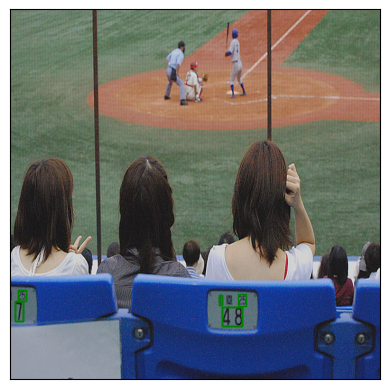

Self Loss: 0.0005722217611037195 
 --------------------------------------------------
Random Comparison 15.412684440612793 
 --------------------------------------------------


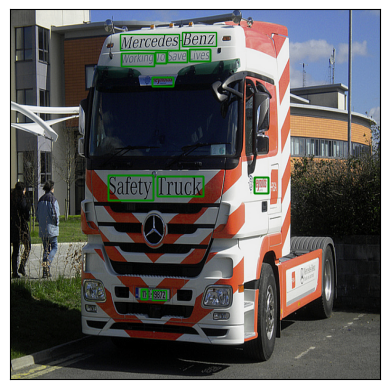

Self Loss: 0.00023243091709446162 
 --------------------------------------------------
Random Comparison 17.04021453857422 
 --------------------------------------------------


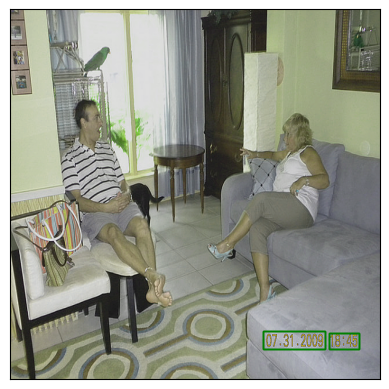

Self Loss: 5.869234155397862e-05 
 --------------------------------------------------
Random Comparison 17.248355865478516 
 --------------------------------------------------


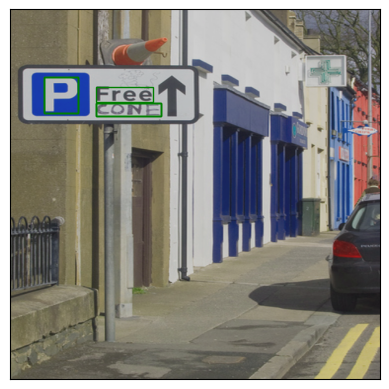

Self Loss: 3.708002986968495e-05 
 --------------------------------------------------
Random Comparison 23.288070678710938 
 --------------------------------------------------


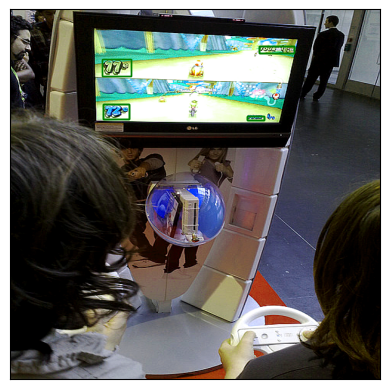

Self Loss: 0.00022130629804451019 
 --------------------------------------------------
Random Comparison 16.800521850585938 
 --------------------------------------------------


In [8]:
sanity_batch = 5
imgb, labelb = train_dataset.get_batch(sanity_batch)

print('Image Batch:', imgb.shape, '\tLabel:', labelb.shape)
print('Image:', imgb[0].shape, '\tLabel:', labelb[0].shape)

def get_loss(label_a, label_b, title='', grid_sizes=[(7, 7), (14, 14), (28, 28)]):
    coarse_size = grid_sizes[0][0] * grid_sizes[0][1] * num_anchors * (5 + num_classes)
    medium_size = grid_sizes[1][0] * grid_sizes[1][1] * num_anchors * (5 + num_classes)
    fine_size = grid_sizes[2][0] * grid_sizes[2][1] * num_anchors * (5 + num_classes)
    coarse_flat, medium_flat, fine_flat = torch.split(label_a, [coarse_size, medium_size, fine_size], dim=0)
    coarse = coarse_flat.view(grid_sizes[0][0], grid_sizes[0][1], num_anchors, (5 + num_classes))
    medium = medium_flat.view(grid_sizes[1][0], grid_sizes[1][1], num_anchors, (5 + num_classes))
    fine = fine_flat.view(grid_sizes[2][0], grid_sizes[2][1], num_anchors, (5 + num_classes))
    predictions = [coarse.unsqueeze(0), medium.unsqueeze(0), fine.unsqueeze(0)]
    print(title, sanity_criterion(predictions, label_b.unsqueeze(0)).item(), '\n', '-' * 50)

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area, box2_area = box1[2] * box1[3], box2[2] * box2[3]
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def show_image_with_bboxes(img, label, num_anchors=3, num_classes=1, grid_sizes=[(7, 7), (14, 14), (28, 28)], anchors=anchors):
    img_np = TF.to_pil_image(img)
    _, ax = plt.subplots(1)
    ax.imshow(img_np)
    ax.set_xticks([])
    ax.set_yticks([])
    coarse_size = grid_sizes[0][0] * grid_sizes[0][1] * num_anchors * (5 + num_classes)
    medium_size = grid_sizes[1][0] * grid_sizes[1][1] * num_anchors * (5 + num_classes)
    fine_size = grid_sizes[2][0] * grid_sizes[2][1] * num_anchors * (5 + num_classes)
    coarse_flat, medium_flat, fine_flat = torch.split(label, [coarse_size, medium_size, fine_size], dim=0)
    coarse = coarse_flat.view(grid_sizes[0][0], grid_sizes[0][1], num_anchors, (5 + num_classes))
    medium = medium_flat.view(grid_sizes[1][0], grid_sizes[1][1], num_anchors, (5 + num_classes))
    fine = fine_flat.view(grid_sizes[2][0], grid_sizes[2][1], num_anchors, (5 + num_classes))
    def draw_boxes(grid, grid_w, grid_h, anchors):
        for y in range(grid_h):
            for x in range(grid_w):
                best_iou, best_anchor_idx = 0, -1
                for a in range(num_anchors):
                    box = grid[y, x, a]
                    if box[4] > 0:
                        anchor_w, anchor_h = anchors[a]
                        w = box[2].item() * anchor_w * img_np.width
                        h = box[3].item() * anchor_h * img_np.height
                        cx = (box[0].item() + x) / grid_w * img_np.width
                        cy = (box[1].item() + y) / grid_h * img_np.height
                        normalized_box = torch.tensor([cx - w / 2, cy - h / 2, w, h])
                        iou = calculate_iou(normalized_box.numpy(), [cx - w / 2, cy - h / 2, w, h])
                        if iou > best_iou:
                            best_iou = iou
                            best_anchor_idx = a
                if best_anchor_idx != -1:
                    best_box = grid[y, x, best_anchor_idx]
                    anchor_w, anchor_h = anchors[best_anchor_idx]
                    w_best = best_box[2].item() * anchor_w * img_np.width
                    h_best = best_box[3].item() * anchor_h * img_np.height
                    cx_best = (best_box[0].item() + x) / grid_w * img_np.width
                    cy_best = (best_box[1].item() + y) / grid_h * img_np.height
                    rect = patches.Rectangle((cx_best - w_best / 2, cy_best - h_best / 2), w_best, h_best,
                                             linewidth=1, edgecolor='g', facecolor='none')
                    ax.add_patch(rect)
    draw_boxes(coarse, grid_sizes[0][0], grid_sizes[0][1], anchors)
    draw_boxes(medium, grid_sizes[1][0], grid_sizes[1][1], anchors)
    draw_boxes(fine, grid_sizes[2][0], grid_sizes[2][1], anchors)
    plt.show()

for i in range(imgb.shape[0]):
    show_image_with_bboxes(imgb[i], labelb[i])
    get_loss(labelb[i], labelb[i], title='Self Loss:')
    another_idx = random.choice([num for num in range(sanity_batch) if num != i])
    get_loss(labelb[i], labelb[another_idx], title='Random Comparison')

---

## Training

In [9]:
train_dataset = COCOText(split="train")
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                           collate_fn=COCOText.collate_fn, pin_memory=True)

val_dataset = COCOText(split="validation")
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, 
                         collate_fn=COCOText.collate_fn, pin_memory=True)

In [10]:
def evaluate(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            with torch.amp.autocast(device_type=str(device)):
                outputs = model(images)
                loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)

def mixup_data(x, y, alpha=0.1):
    # Intentionally mess up image-to-label relationship for alpha percentage of batch entries
    # Helps to avoid overfitting (when not overdone)
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
        batch_size = x.size(0)
        index = torch.randperm(batch_size).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam
    else:
        return x, y, y, 1

In [11]:
model = MobileYOLOv3(num_classes=num_classes, dropout_rate=dropout_rate, anchors=torch.tensor(anchors, dtype=torch.float32, device=device)).to(device)
model = torch.compile(model)
criterion = YoLoss()

base_optimizer = torch.optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': learning_rate * 0.8, 'weight_decay': weight_decay * 0.6},
    {'params': model.conv_7.parameters()},
    {'params': model.eca_7.parameters()},
    {'params': model.det1.parameters()},
    {'params': model.r_1024_128.parameters()},
    {'params': model.r_48_128.parameters()},
    {'params': model.conv_14.parameters()},
    {'params': model.eca_14.parameters()},
    {'params': model.det2.parameters()},
    {'params': model.r_512_64.parameters()},
    {'params': model.r_24_64.parameters()},
    {'params': model.conv_28.parameters()},
    {'params': model.eca_28.parameters()},
    {'params': model.det3.parameters()},
], lr=learning_rate, weight_decay=weight_decay)

optimizer = optim.Lookahead(base_optimizer, k=optim_k, alpha=optim_alpha)
scheduler = OneCycleLR(optimizer, max_lr=learning_rate*2, epochs=num_epochs, steps_per_epoch=len(train_loader),
                       pct_start=0.3, anneal_strategy='cos', div_factor=10.0, final_div_factor=10000.0)
scaler = torch.amp.GradScaler(enabled=(str(device) != 'cpu'))

In [ ]:
lossi, losst = [], []
lowsi = float('inf')

print(f'Batch Size:\t {batch_size}\n',
      f'Learning Rate:\t {learning_rate}\n',
      f'Weight Decay:\t {weight_decay}\n',
      f'Num Epochs:\t {num_epochs}\n',
      f'LR Warmup:\t {lr_warmup}\n',
      f'Optim K:\t {optim_k}\n',
      f'Optim Alpha:\t {optim_alpha}\n',
      f'Prune Amount:\t {prune_amount}\n',
      f'Target Architecture:\t {t_arch}\n',
      f'Num Anchors:\t {num_anchors}\n',
      f'Dropout Rate:\t {dropout_rate}\n\n')

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for files, targets in train_loader:
        files = files.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        mixed_files, targets_a, targets_b, lam = mixup_data(files, targets)
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type=str(device)):
            logits = model(mixed_files)
            loss_a = criterion(logits, targets_a)
            loss_b = criterion(logits, targets_b)
            loss = lam * loss_a + (1 - lam) * loss_b # Mixup Loss Calculation

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        
    epoch_loss /= len(train_loader)
    lossi.append(epoch_loss)
    t_loss = evaluate(model, criterion, val_loader, device)
    losst.append(t_loss)

    if 'cuda' == str(device):
        gc.collect()
        torch.cuda.empty_cache()
    
    print(f'Epoch [{epoch+1:3}/{num_epochs}] | Train: {epoch_loss:8.6f} | Test: {t_loss:8.6f} | LR: {optimizer.param_groups[-1]["lr"]:.6f}')

Batch Size:	 2
 Learning Rate:	 0.0004
 Weight Decay:	 0.0001
 Num Epochs:	 400
 LR Warmup:	 40.0
 Optim K:	 5
 Optim Alpha:	 0.3
 Prune Amount:	 0.2
 Target Architecture:	 cuda
 Num Anchors:	 3
 Dropout Rate:	 0.4




Exception ignored in: <function ExactWeakKeyDictionary.__setitem__.<locals>.<lambda> at 0x79d885acd1c0>
Traceback (most recent call last):
  File "/home/marcus/.conda/envs/ai/lib/python3.12/site-packages/torch/_dynamo/utils.py", line 542, in <lambda>
    self.refs[idx] = weakref.ref(key, lambda ref: self._remove_id(idx))

KeyboardInterrupt: 


In [13]:
torch.save(model.state_dict(), f'solid_{model_path}')

---

## Loss Graph

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), lossi, label="Training Loss", color='blue', marker='o', linestyle='-', markersize=3)
plt.plot(range(num_epochs), losst, label="Test Loss", color="red", marker='o', linestyle='-', markersize=3)

plt.title('Loss Curves', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(0, num_epochs, 50))
plt.legend(loc='upper right')
plt.show();

---

## Pruning & Quantization

In [ ]:
def prune_model(model, amount):
    def prune_conv(conv, amount):
        prune.ln_structured(conv, name='weight', amount=amount, n=2, dim=0)

    for _, module in model.named_modules():
        if isinstance(module, DSConv):
            prune_conv(module.depthwise, amount)
            prune_conv(module.pointwise, amount)
        elif isinstance(module, Resizer):
            if isinstance(module.conv, DSConv):
                prune_conv(module.conv.depthwise, amount)
                prune_conv(module.conv.pointwise, amount)
            else:
                prune_conv(module.conv, amount)
        elif isinstance(module, nn.Conv2d):
            prune_conv(module, amount)

    parameters_to_prune = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            parameters_to_prune.append((module, 'weight'))
        elif isinstance(module, DSConv):
            parameters_to_prune.extend([(module.depthwise, 'weight'), (module.pointwise, 'weight')])
        elif isinstance(module, nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount)
    return model

def quantize_model(model, device):
    """
    Crunch numeric precision of weights and activations.
    """
    model = model.cpu() # Works only on CPU
    quantized_model = torch.quantization.quantize_dynamic(model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8, inplace=True) # inplace=True avoids deepcopy issues
    return quantized_model.to(device)

def lift_prune_mask(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight_mask'):
                module.weight.data *= module.weight_mask
                prune.remove(module, 'weight')
            elif hasattr(module, 'weight_orig'):
                # If there's a weight_orig but no mask, it means pruning was applied but the mask was removed
                module.weight.data = module.weight_orig.data
                delattr(module, 'weight_orig')
        elif isinstance(module, DSConv):
            for conv in [module.depthwise, module.pointwise]:
                if hasattr(conv, 'weight_mask'):
                    conv.weight.data *= conv.weight_mask
                    prune.remove(conv, 'weight')
                elif hasattr(conv, 'weight_orig'):
                    conv.weight.data = conv.weight_orig.data
                    delattr(conv, 'weight_orig')
        elif isinstance(module, Resizer):
            if isinstance(module.conv, DSConv):
                for conv in [module.conv.depthwise, module.conv.pointwise]:
                    if hasattr(conv, 'weight_mask'):
                        conv.weight.data *= conv.weight_mask
                        prune.remove(conv, 'weight')
                    elif hasattr(conv, 'weight_orig'):
                        conv.weight.data = conv.weight_orig.data
                        delattr(conv, 'weight_orig')
            else:
                if hasattr(module.conv, 'weight_mask'):
                    module.conv.weight.data *= module.conv.weight_mask
                    prune.remove(module.conv, 'weight')
                elif hasattr(module.conv, 'weight_orig'):
                    module.conv.weight.data = module.conv.weight_orig.data
                    delattr(module.conv, 'weight_orig')
    return model

In [ ]:
# Prune, Quantize
pruned_model = prune_model(model, amount=prune_amount)
lifted_model = lift_prune_mask(pruned_model)
quantized_model = quantize_model(lifted_model, device)

# Save the quantized model
torch.save(quantized_model.state_dict(), model_path)

---

## Inference

In [15]:
def load_model(model_class, num_classes, model_path, device='cpu'):
    """
    Load a PyTorch model for inference on the target device, regardless of where it was originally trained.
    """
    if isinstance(device, str):
        device = torch.device(device)

    # Load to CPU first
    state_dict = torch.load(model_path, map_location=device, weights_only=False)
    
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']

    # Remove 'module.' prefix caused by SWA
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    # Remove pruning-related keys
    new_state_dict = {}
    for key, value in state_dict.items():
        if 'weight_mask' not in key:
            new_key = key.replace('weight_orig', 'weight')
            new_state_dict[new_key] = value
    
    model = model_class(num_classes=num_classes, dropout_rate=dropout_rate, anchors=torch.tensor(anchors, dtype=torch.float32, device=device)).to(device)
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    return model

In [16]:
model = load_model(MobileYOLOv3, num_classes, model_path, device='cuda')

In [36]:
def visualize_inference(model, dataset, num_anchors=3, num_classes=1, grid_sizes=[(7, 7), (14, 14), (28, 28)], anchors=anchors):
    img, _ = dataset[random.randint(0, len(dataset) - 1)]
    prediction = model(img.unsqueeze(0).to(device))
    prediction = [p.squeeze(0) for p in prediction]
    _, ax = plt.subplots(1)
    img_np = TF.to_pil_image(img)
    ax.imshow(img_np)    
    ax.set_xticks([])
    ax.set_yticks([])

    def draw_boxes(grid, grid_w, grid_h, anchors):
        for y in range(grid_h):
            for x in range(grid_w):
                best_iou, best_anchor_idx = 0, -1
                for a in range(num_anchors):
                    box = grid[y, x, a]
                    if box[4] > 0.9:
                        anchor_w, anchor_h = anchors[a]
                        w = box[2].item() * anchor_w * img_np.width  # Width
                        h = box[3].item() * anchor_h * img_np.height # Height
                        cx = (box[0].item() + x) / grid_w * img_np.width   # Center x
                        cy = (box[1].item() + y) / grid_h * img_np.height  # Center y
                        # Create a normalized bounding box for IoU calculation
                        normalized_box = torch.tensor([cx - w / 2, cy - h / 2, w, h])
                        # Calculate IoU with the current anchor
                        iou = calculate_iou(normalized_box.numpy(), [cx - w / 2, cy - h / 2, w, h])
                        # Update best IoU and corresponding anchor index
                        if iou > best_iou:
                            best_iou = iou
                            best_anchor_idx = a
                if best_anchor_idx != -1:
                    # Draw the bounding box with the best anchor
                    best_box = grid[y, x, best_anchor_idx]
                    anchor_w, anchor_h = anchors[best_anchor_idx]
                    w_best = best_box[2].item() * anchor_w * img_np.width  # Width using best anchor
                    h_best = best_box[3].item() * anchor_h * img_np.height # Height using best anchor
                    cx_best = (best_box[0].item() + x) / grid_w * img_np.width   # Center x using best anchor
                    cy_best = (best_box[1].item() + y) / grid_h * img_np.height  # Center y using best anchor
                    rect = patches.Rectangle((cx_best - w_best / 2, cy_best - h_best / 2), w_best, h_best,
                                             linewidth=1, edgecolor='g', facecolor='none')
                    ax.add_patch(rect)

    draw_boxes(prediction[0], grid_sizes[0][0], grid_sizes[0][1], anchors)
    draw_boxes(prediction[1], grid_sizes[1][0], grid_sizes[1][1], anchors)
    draw_boxes(prediction[2], grid_sizes[2][0], grid_sizes[2][1], anchors)
    plt.show()

In [ ]:
visualize_inference(model, train_dataset)